In [1]:
push!(LOAD_PATH, "/Users/jayyao/Documents/Research/TraceFormula/Module")
using GridapEM
using Gridap
using DelimitedFiles
using KrylovKit
using LinearAlgebra
using GLMakie
using GridapMakie
using Interpolations

In [2]:
include("/Users/jayyao/Documents/Research/TraceFormula/Module/DefaultParameters.jl")

# Change default geometry parameters
L = 2.0           # Length of the normal region
H = 2.0           # Height of the normal region
Hd = 1.5          # Height of the design region
Ld = 0.5          # Length of the design region

xd = -0.2         # Center off-set of the design region
xt = 0.2          # Distance of the target line
resol = 60.0      # Number of points per wavelength
l1 = λ/resol      # Normal region
l2 = l1/2.0       # Design region
l3 = l1         # PML

# Create mesh file
geo_param = RecRecGeometry(L, H, Ld, Hd, xd, xt, dpml, l1, l2, l3)
meshfile_name = "geometry.msh"
#MeshGenerator(geo_param, meshfile_name)

# Apply gridap finite element analysis to mesh file
gridap = GridapFE(meshfile_name, 1, 2, ["DirichletEdges", "DirichletNodes"], ["DesignNodes", "DesignEdges"], ["Target", "Target1", "Target2"], ["Source"], flag_f)
#run(`gmsh geometry.msh`)

# Change default physics parameters
kb = VectorValue(2*π*0.,0)
LHp=[L / 2, H / 2]  # Start of PML for x,y > 0
LHn=[L / 2, H / 2]  # Start of PML for x,y < 0
ϵ3 = 12.0
wg_center = [(L-Ld)/4+dpml/2+Ld/2+0.005*λ+xd/2, 0]
wg_size = [(L-Ld)/2+dpml-xd, λ/2/sqrt(ϵ3)]
#wg_center = [0, 0]
#wg_size = [L + 2 * dpml, λ / 2 / sqrt(ϵ3)]
phys = PhysicalParameters(k, kb, ω, ϵ1, ϵ2, ϵ3, ϵd, μ, R, σs, dpml, LHp, LHn, wg_center, wg_size)

# Change default control parameters
Bρ = true
ρv = 0.5
β = 80.0

control = ControllingParameters(flag_f, flag_t, r, β, η, α, nparts, nkx, K, Amp, Bρ, ρv, c, ηe, ηd)



Info    : Reading 'geometry.msh'...
Info    : 66 entities
Info    : 51784 nodes
Info    : 104400 elements
Info    : Done reading 'geometry.msh'


ControllingParameters(true, true, [0.02, 0.02], 80.0, 0.5, 0.0005, 15, 30, 20, 1.0, true, 0.5, 0.0, 0.75, 0.25)

In [3]:
EigMode = open(readdlm,"Eigenmode.txt")

A_x = EigMode[:,1]
knots = (A_x,)
Hzi = EigMode[:,2]
Eyi = EigMode[:,3]
Hz_eigy = Interpolations.interpolate(knots, Hzi, Gridded(Linear()))
Ey_eigy = Interpolations.interpolate(knots, Eyi, Gridded(Linear()))
Hz_eig(x) = Hz_eigy(x[2])*cis(-1.654*k*(x[1]))
Ey_eig(x) = Ey_eigy(x[2])*cis(-1.654*k*(x[1]))
#Hz_eig(x) = Hz_eigy(x[2])*cis(-2.854*k*(x[1]))
#Ey_eig(x) = Ey_eigy(x[2])*cis(-2.854*k*(x[1]))
Mode_norm = Hzi'*Eyi*(A_x[2]-A_x[1])
q_vec=VectorO(Ey_eig, Mode_norm; gridap)
Mode_norm
#N = 201
#Larray = range(-0.5,0.5;length=N)
#H_itpr = zeros(N)
#for i=1:N
#    H_itpr[i] = itpr[Larray[i]]
#end

#lines(Larray,H_itpr)

0.2139839801209827

In [8]:
ρ_init = ones(gridap.np) * 0.5
#ρW_temp = readdlm("ρW_opt_value.txt", Float64)
#ρW_temp = ρW_temp[:]
#ρ_init = ρW_temp[1 : gridap.np]
#ρ_init[ρ_init .< 0.5] .= 0
#ρ_init[ρ_init .>= 0.5] .= 1.0
r = [0.02 * λ, 0.02 * λ]  # Filter radius
#Q_list = [50, 100, 500, 1000, 1000, 1000, 1000]
Q_list = [1000, 1000, 1000, 1000, 1000]
#β_list = [5.0, 10.0, 20.0, 30.0, 40.0, 60.0, 80.0]
β_list = [80.0, 80.0, 80.0, 80.0, 80.0]

g_opt = 0
for bi = 1 : 2
    β = β_list[bi]
    α = 1.0 / (2 * Q_list[bi])
    phys = PhysicalParameters(k, kb, ω, ϵ1, ϵ2, ϵ3, ϵd, μ, R, σs, dpml, LHp, LHn, wg_center, wg_size)
    control = ControllingParameters(flag_f, flag_t, r, β, η, α, nparts, nkx, K, Amp, Bρ, ρv, c, ηe, ηd)

    if bi == 1
        g_opt, ρ_opt = gvρ_optimize([], q_vec, 1e-12, 200; phys, control, gridap)
    
    else
        g_opt, ρ_opt = gvρ_optimize([], q_vec, 1e-12, 200; phys, control, gridap)
    end
    if isfile("ρ_opt.value.txt")
        run(`rm ρ_opt_value.txt`)
    end
    open("ρ_opt_value.txt", "w") do iop
        for i = 1 : length(ρ_opt)
            ρ_temp = ρ_opt[i]
            write(iop, "$ρ_temp \n")
        end
    end
    open("g_opt_value.txt", "a") do io
        write(io, "$g_opt \n")
    end
end
@show g_opt

numevals = opt.numevals = 200
numevals = opt.numevals = 200
g_opt = 1452.5256876170695


1452.5256876170695

sum(∫(ρth) * gridap.dΩ_d) / sum(∫(1) * gridap.dΩ_d) = 0.49999824093589634


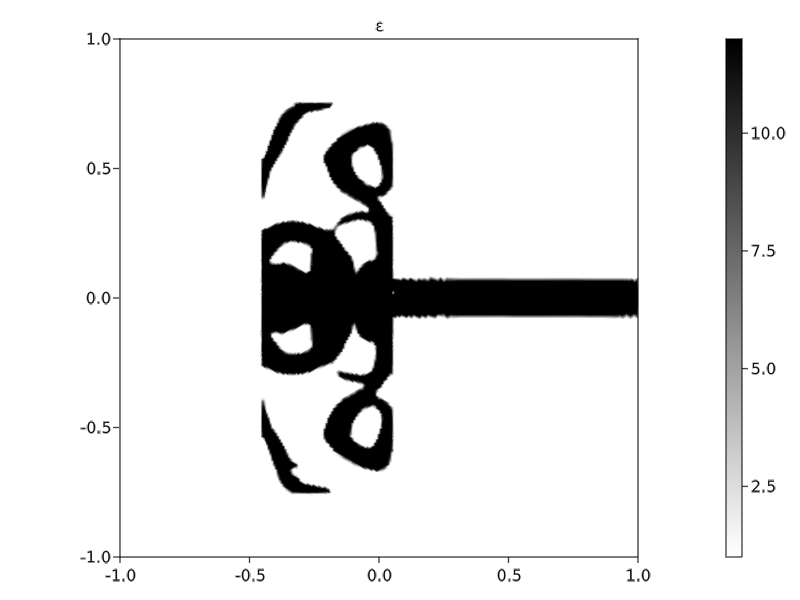

In [27]:
# Output and view
ImportFromFile = true
N = num_free_dofs(gridap.FE_U)
if ImportFromFile
    ρ_max = readdlm("ρ_opt_value.txt", Float64)
    ρ0 = ρ_max[:]
else
    ρ0 = ones(gridap.np)
end
 
ρf_vec = ρf_ρ0(ρ0; control, gridap)
ρfh = FEFunction(gridap.FE_Pf, ρf_vec)
ρth = (ρf -> Threshold(ρf; control)) ∘ ρfh
        
A_mat = MatrixA(ρth; phys, control, gridap)
B_mat = MatrixB(ρth; control, gridap)
@show sum(∫(ρth)gridap.dΩ_d) / sum(∫(1)gridap.dΩ_d)

A0_mat = MatrixA0(phys, control, gridap)

G_ii, V_raw, info = eigsolve(x -> A_mat \ (A0_mat * x), rand(ComplexF64, N), 10, :LM)

V_mat = rand(ComplexF64, N, control.K)
for ib = 1 : 10
    V_mat[:, ib] = V_raw[ib]
end
v_vec = A_mat' \ q_vec
vh_eig = FEFunction(gridap.FE_U, V_mat[:, 1])
vh = FEFunction(gridap.FE_U, v_vec)

fig, ax, plt = plot(gridap.Ω, real( (x->(1/GridapEM.ξ0(x; phys))) + 11 * ρth), colormap = :binary)
Colorbar(fig[1,2], plt)
ax.aspect = AxisAspect(L/(H))
ax.title = "ε"
limits!(ax, -L/2, L/2, -phys.LHn[2], phys.LHp[2])
save("Results/shape.png", fig)
fig

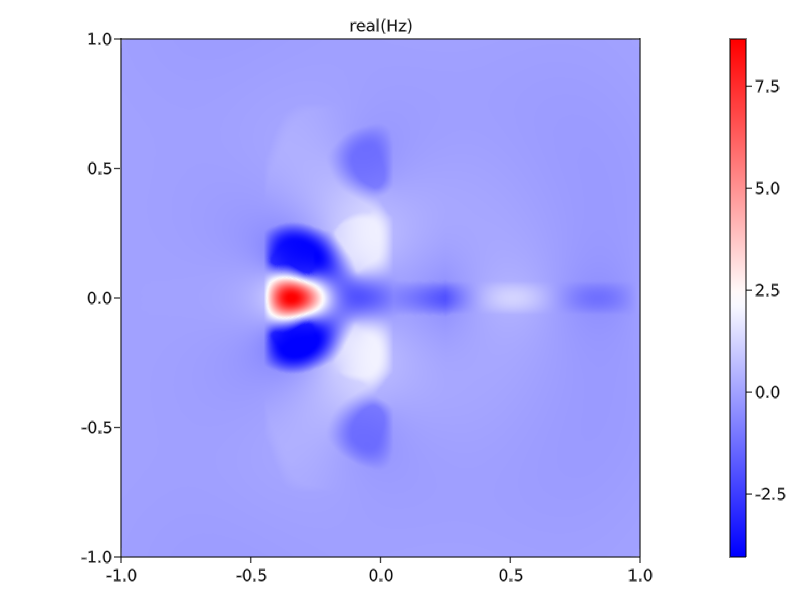

In [12]:
uh_eig = FEFunction(gridap.FE_U, V_mat[:, 1])
uh = FEFunction(gridap.FE_U, v_vec)
fig1, ax1, plt1 = plot(gridap.Ω, real(uh), colormap = :bwr)
Colorbar(fig1[1,2], plt1)
ax1.aspect = AxisAspect(L/(H))
ax1.title = "real(Hz)"
limits!(ax1, -L/2, L/2, -phys.LHn[2], phys.LHp[2])
save("Results/s_mode.png", fig1)
fig2, ax2, plt2 = plot(gridap.Ω, real(uh_eig), colormap = :bwr)
Colorbar(fig2[1,2], plt2)
ax2.aspect = AxisAspect(L/(H))
ax2.title = "real(Hz)"
limits!(ax2, -L/2, L/2, -phys.LHn[2], phys.LHp[2])
save("Results/t_mode.png", fig2)
fig1

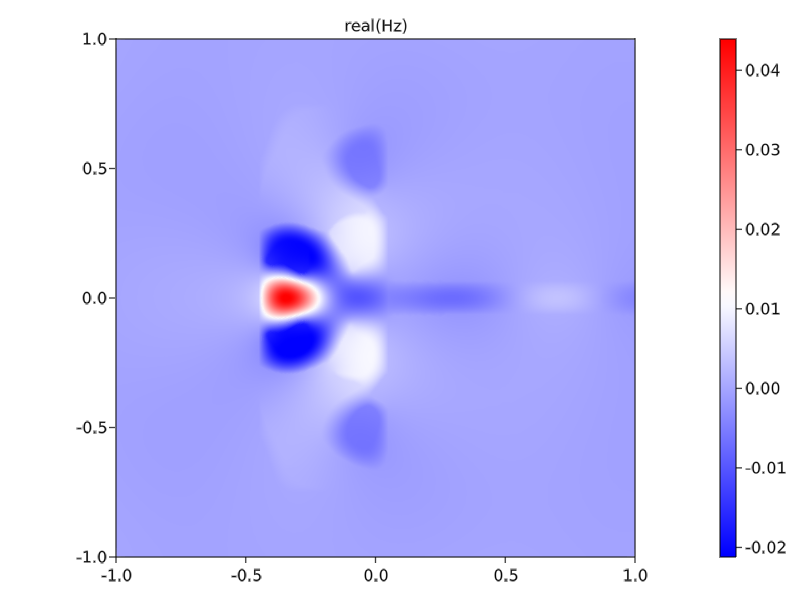

In [13]:
fig2

In [25]:
#1:b,2:-a,3:a,s:-b
normal_vec = VectorValue(1,0)
O_mat = assemble_matrix(gridap.FE_U,gridap.FE_V) do u,v
    ∫( 1im/4/k*((x->GridapEM.ξ0(x; phys))*((u*∇(v)-v*∇(u))⋅normal_vec)) )gridap.dΓ_t[1]
end
G_ii,V_raw,info = eigsolve(x->MatrixG(x;A_mat,B_mat,O_mat),rand(ComplexF64,N),5,:LM)
sum((G_ii))
#u_vec'*Q_mat*u_vec

-13.138173204142529 - 2.360113116376215e-12im

In [24]:
GridapEM.g_v(v_vec;B_mat)*Mode_norm/2

2.561834684700668

In [26]:
powers=[126.10721850675672, 11.806703605522264, 11.98660019907219, 44.81160680928318]
wgpower_opt = 125
powers_uni = [14.640808550982689, 13.51704593414934, 13.526541233284446, 13.138173204142529]
wgpower_uni = 2.561834684700668
wgpower_opt/sum(powers), wgpower_uni/sum(powers_uni)

(0.6419733612103639, 0.046729562934554415)

In [ ]:
N = num_free_dofs(gridap.FE_U)
ρ0 = rand(gridap.np) * 1
δρ = rand(gridap.np) * 1e-6

grad = zeros(gridap.np )
g1 = gv_ρ(ρ0 + δρ, []; q_vec, phys, control, gridap)
g0 = gv_ρ(ρ0, grad; q_vec, phys, control, gridap)
g1 - g0, grad' * δρ

In [ ]:
l_temp(v) = ∫(v*Ey_eig)*gridap.dΓ_s
b_vec = assemble_vector(l_temp,gridap.FE_V)
u_vec=A_mat\(b_vec)
uh =FEFunction(gridap.FE_U,u_vec)
unorm=sum(∫( uh'*uh )gridap.dΓ_s)
uhn = uh/sqrt(unorm)
u_vec=u_vec./sqrt(unorm)

fig2, ax2, plt2 = plot(gridap.Ω, real(uhn), colormap = :bwr)
Colorbar(fig2[1,2], plt2)
ax2.aspect = AxisAspect(L/(H))
ax2.title = "real(Hz)"
limits!(ax2, -L/2, L/2, -phys.LHn[2], phys.LHp[2])
fig2

In [ ]:
abs(u_vec'*O_mat*u_vec), Mode_norm/2